In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to directories
path = '/content/drive/MyDrive/TFM - Neural ODEs/Neural ODE/df.csv'

# Read data
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(path, sep=',', index_col='datetime', parse_dates=['datetime'], date_parser=date_parser)
df.head()

Mounted at /content/drive


<ipython-input-2-f9765ec2bc53>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


,demand,wind,price,day_of_week
datetime,,,,
2018-01-01 00:00:00,22718.1,11487.7,6.74,7
2018-01-01 01:00:00,21510.8,10123.2,4.74,7
2018-01-01 02:00:00,19865.8,8763.5,3.66,7
2018-01-01 03:00:00,19248.3,5661.2,2.30,7
2018-01-01 04:00:00,18632.1,5689.0,2.30,7


In [ ]:
# Training set. From Wednesday to Wednesday. 14 months
train_df = df.loc['2018-03-07 00:00':'2019-04-24 23:00']
train_spot = train_df.values
train_df

,demand,wind,price,day_of_week
datetime,,,,
2018-03-07 00:00:00,27975.8,9443.8,41.83,2
2018-03-07 01:00:00,26033.7,9773.2,39.80,2
2018-03-07 02:00:00,24525.2,9876.3,37.81,2
2018-03-07 03:00:00,24230.8,9864.1,37.61,2
2018-03-07 04:00:00,24044.6,9369.3,37.54,2
...,...,...,...,...
2019-04-24 19:00:00,30490.3,14519.4,39.45,2
2019-04-24 20:00:00,31700.7,14414.6,42.08,2
2019-04-24 21:00:00,33190.0,14108.6,49.59,2


In [ ]:
# Validation set. 3 months
validation_df = df.loc['2019-05-01 00:00':'2019-07-31 23:00']
validation_spot = validation_df.values
validation_df

,demand,wind,price,day_of_week
datetime,,,,
2019-05-01 00:00:00,24352.5,4331.5,57.63,9
2019-05-01 01:00:00,22528.2,4177.0,56.56,9
2019-05-01 02:00:00,21539.7,3827.5,55.52,9
2019-05-01 03:00:00,20754.9,3580.3,55.71,9
2019-05-01 04:00:00,20548.3,3354.3,55.00,9
...,...,...,...,...
2019-07-31 19:00:00,31992.5,6593.2,48.79,2
2019-07-31 20:00:00,31728.5,7014.2,48.17,2
2019-07-31 21:00:00,31798.1,7277.3,48.79,2


In [ ]:
# Test set. 3 months
test_df = df.loc['2019-08-07 00:00':'2019-10-30 23:00']
test_spot = test_df.values
test_df

,demand,wind,price,day_of_week
datetime,,,,
2019-08-07 00:00:00,28005.4,4676.8,49.76,2
2019-08-07 01:00:00,26047.0,4544.3,46.21,2
2019-08-07 02:00:00,25063.2,4522.2,43.51,2
2019-08-07 03:00:00,24326.0,4329.2,41.75,2
2019-08-07 04:00:00,24113.1,3897.1,42.80,2
...,...,...,...,...
2019-10-30 19:00:00,32587.8,4565.3,60.00,2
2019-10-30 20:00:00,32249.4,4990.7,56.85,2
2019-10-30 21:00:00,31105.7,5071.1,55.50,2


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Declaration of the scaler
scaler_price = MinMaxScaler(feature_range=(0, 1))

# Scaler is fitted with the training data
scaler_price.fit(train_df[["price"]])

# Scaling the 'Electricity Price' column for each set
train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
test_df.loc[:, "price"] = scaler_price.transform(test_df[["price"]])

<ipython-input-6-5f59fd52c649>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
<ipython-input-6-5f59fd52c649>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
<ipython-input-6-5f59fd52c649>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [ ]:
def create_windows(df, window_size=168, forecast_size=24):
    input_data, output_data = [], []

    # Step through the dataframe with a step size of 168 (7*24)
    for i in range(window_size, len(df) - forecast_size + 1, window_size):
        inputs = df.iloc[i-window_size:i]["price"].values
        outputs = df.iloc[i:i+forecast_size]["price"].values
        input_data.append(inputs)
        output_data.append(outputs)

    return np.array(input_data), np.array(output_data)

window_size = 168
forecast_size = 24

X_train, Y_train = create_windows(train_df, window_size, forecast_size)
X_validation, Y_validation = create_windows(validation_df, window_size, forecast_size)
X_test, Y_test = create_windows(test_df, window_size, forecast_size)

In [ ]:
# Model definition
CNN_LSTM_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(500, return_sequences=True),
  tf.keras.layers.LSTM(500, return_sequences=True),
  tf.keras.layers.LSTM(500),
  tf.keras.layers.Dense(24),
])

CNN_LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 64)           256       
                                                                 
 lstm (LSTM)                 (None, 168, 500)          1130000   
                                                                 
 lstm_1 (LSTM)               (None, 168, 500)          2002000   
                                                                 
 lstm_2 (LSTM)               (None, 500)               2002000   
                                                                 
 dense (Dense)               (None, 24)                12024     
                                                                 
Total params: 5,146,280
Trainable params: 5,146,280
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LR = 0.01
loss = tf.keras.losses.MeanAbsoluteError()
# reset_states = ResetStatesCallback()
optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)

CNN_LSTM_model.compile(optimizer = optimizer, loss = loss, metrics = 'mae')
save_model = ModelCheckpoint("CNN_LSTM_model.h5", monitor='val_loss', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=100)

history = CNN_LSTM_model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs = 500, callbacks=[save_model, early_stopping])

Epoch 1/500
2/2 [==============================] - 17s 2s/step - loss: 0.6961 - mae: 0.6961 - val_loss: 0.5838 - val_mae: 0.5838
Epoch 2/500
2/2 [==============================] - 0s 234ms/step - loss: 0.6872 - mae: 0.6872 - val_loss: 0.5697 - val_mae: 0.5697
Epoch 3/500
2/2 [==============================] - 0s 220ms/step - loss: 0.6709 - mae: 0.6709 - val_loss: 0.5495 - val_mae: 0.5495
Epoch 4/500
2/2 [==============================] - 0s 240ms/step - loss: 0.6484 - mae: 0.6484 - val_loss: 0.5239 - val_mae: 0.5239
Epoch 5/500
2/2 [==============================] - 0s 213ms/step - loss: 0.6205 - mae: 0.6205 - val_loss: 0.4931 - val_mae: 0.4931
Epoch 6/500
2/2 [==============================] - 0s 263ms/step - loss: 0.5867 - mae: 0.5867 - val_loss: 0.4562 - val_mae: 0.4562
Epoch 7/500
2/2 [==============================] - 2s 2s/step - loss: 0.5463 - mae: 0.5463 - val_loss: 0.4111 - val_mae: 0.4111
Epoch 8/500
2/2 [==============================] - 0s 242ms/step - loss: 0.4965 - mae: 0

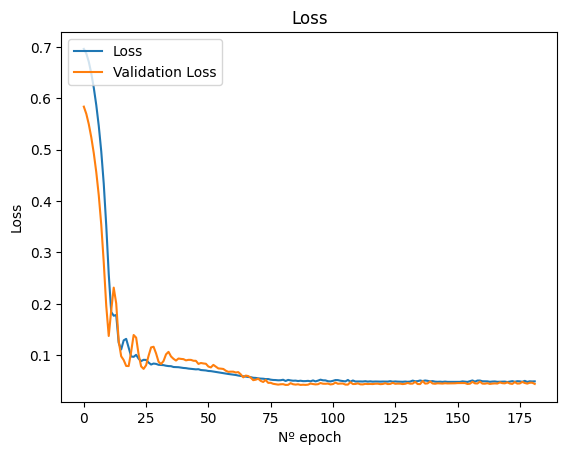

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Nº epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Loading the best model
CNN_LSTM_model = tf.keras.models.load_model('CNN_LSTM_model.h5')

# Forecasting the next 24h per window
test_predictions = CNN_LSTM_model.predict(X_test)

1/1 [==============================] - 1s 994ms/step


In [ ]:
# Scaling back the forecasts and actual values
predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(Y_test.squeeze())

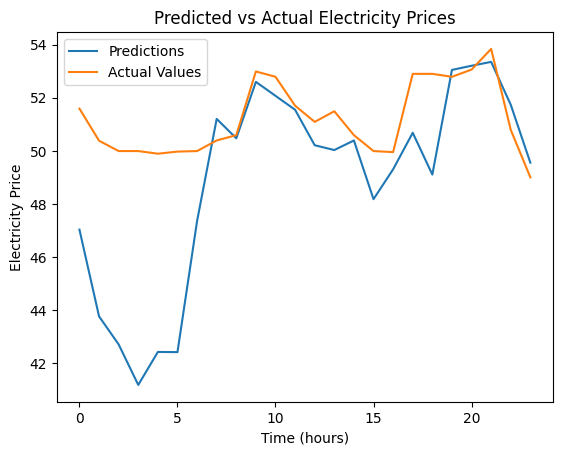

In [ ]:
# Figure and axes for the plot
fig, ax = plt.subplots()

# Ploting the forecasts and actual values
ax.plot(predictions[2], label='Predictions')
ax.plot(y_test[2], label='Actual Values')

# Legend and labels to the plot
ax.legend()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Electricity Price')
ax.set_title('Predicted vs Actual Electricity Prices')

# Plot
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  17.287125930123718
MAE:  3.2399159905645583


In [ ]:
# Histogram of residuals
def residual_histogram(y_true, y_pred, step):
    # copy of the input lists
    true = y_true[:]
    pred = y_pred[:]
    # empty list to allocate residuals
    residual = []
    if len(true) ==len(pred):
        for cicle in range(len(true)):
            for item in range(len(true[cicle])):
                residual.append(true[cicle][item] - pred[cicle][item])

    minim = min(residual)
    maxim = max(residual)

    bins = int(abs((maxim - minim) / step))

    df = pd.DataFrame(residual)
    hist = df.hist(bins = bins)
    return residual

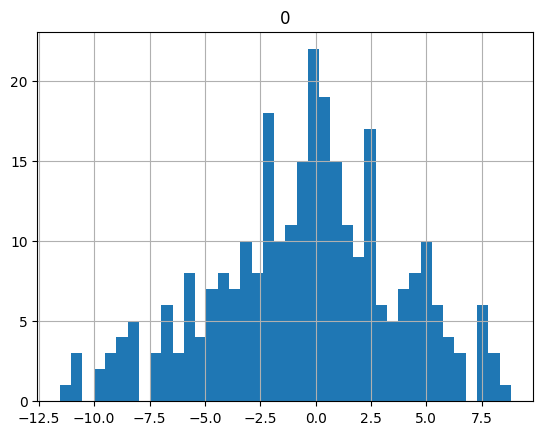

In [ ]:
residuals = residual_histogram(y_test, predictions, 0.5)